In [1]:
import os
import numpy as np
import nibabel as nib
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
import helper_functions.visualizations as vis
import importlib
import helper_functions.reshape_data as rd
import helper_functions.filter_CT as fct

import scipy.ndimage as ndimage

In [21]:
root_data_dir = '/Users/akre96/Documents/GradSchool/Class/BE223A/BE223A_2019/data' # Change for different systems
subject = 'subject_1'

# 'b' images seem to have fewer things around them, no pins in either
fluoro_jpeg_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'fluoro_' + subject + '.jpg'
    )
)
hull_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'hull_' + subject + '.nii'
    )
)

preop_CT_path = os.path.join(
    root_data_dir,
    os.path.join(
        subject,
        'preopCT_' + subject + '.nii'
    )
)

In [22]:
preop_CT = nib.load(preop_CT_path)
preop_CT_data = preop_CT.get_fdata()
preop_CT_data.shape


(256, 256, 176)

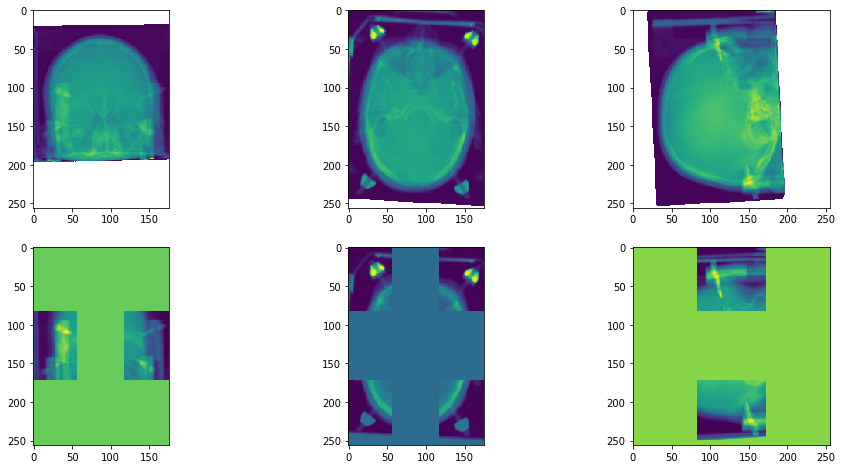

In [23]:
# Remove middle sections and edges to clean image
importlib.reload(fct)
filtered = fct.remove_ct_blocks(preop_CT_data, 35, 35, 35)
axes = vis.compare_filtered_original(preop_CT_data, filtered)

In [ ]:
importlib.reload(rd)
long_data = rd.voxels_to_4D_sample(preop_CT_data, step_size=1)

In [ ]:
importlib.reload(vis)
ax = vis.quick_plot_3D(long_data, step_size=1, is_long=True)
ax.view_init(30, 30)


In [ ]:
filtered = ndimage.gaussian_filter(preop_CT_data, sigma=1)
sharpened = preop_CT_data - filtered

In [ ]:
importlib.reload(rd)
filtered_long = rd.voxels_to_4D_sample(sharpened, step_size=1)

In [ ]:
importlib.reload(vis)
ax = vis.quick_plot_3D(filtered_long, step_size=1, is_long=True)
ax.view_init(60, 60)

In [ ]:
importlib.reload(vis)
#filtered = ndimage.gaussian_gradient_magnitude(preop_CT_data, sigma=.5)
#filtered = ndimage.maximum_filter(preop_CT_data, size=5)
filtered = ndimage.rank_filter(preop_CT_data, rank=2, size=10)

axes = vis.compare_filtered_original(preop_CT_data, filtered)

In [ ]:
sub = preop_CT_data - filtered
axes = vis.compare_filtered_original(preop_CT_data, sub)

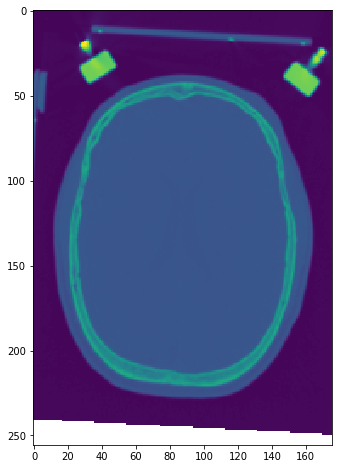

In [24]:
# 
importlib.reload(vis)
vis.plot_slice(preop_CT_data, 'j', 100)

In [ ]:
importlib.reload(rd)
w_bulk_slice = rd.get_slice(preop_CT_data, 'j', 100)

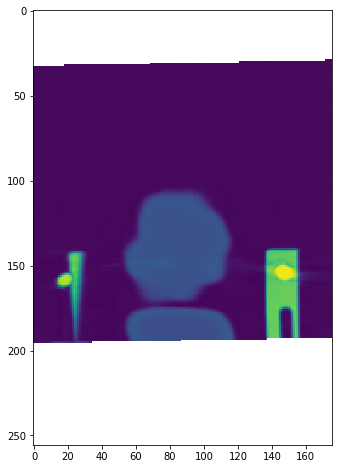

In [25]:
# 
importlib.reload(vis)
vis.plot_slice(preop_CT_data, 'i', 230)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11e47e358>,
      dtype=object)

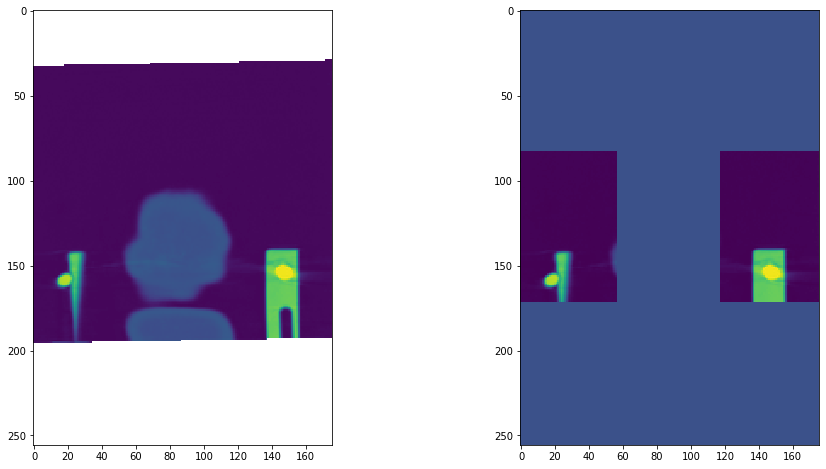

In [29]:
#
importlib.reload(vis)
vis.compare_slices([preop_CT_data, filtered], ['i'] * 2, [230] * 2)